# Hybrid model for energy demand in France

First predict demand using only climate variables.
Then, train a model on the predictions using non-climate stuff like weekends, month etc.

In [6]:
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.inspection import permutation_importance

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from scipy.stats import pearsonr, randint, uniform
from scipy.spatial.distance import correlation

import matplotlib.pyplot as plt

### Note:

You will need to change the kernel to ml_env to use `mlxtend`

In [1]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

In [4]:
region = "FR"

### Demand

In [7]:
demand = pd.read_csv(
    "/g/data/w42/dr6273/work/data/ENTSOE/ENTSOE_daily_demand_2006-2018.csv",
    index_col=0,
    parse_dates=True
)

In [8]:
demand = demand[demand["Country"] == region]["Power (MWh/day)"]

In [9]:
dem_da = xr.DataArray(
    demand.squeeze(),
    dims=["time"],
    coords={"time": demand.index.values}
)

In [10]:
dem_da = dem_da.expand_dims({"region": [region]})

In [11]:
dem_da = fn.detrend_dim(dem_da, "time") + dem_da.mean("time")

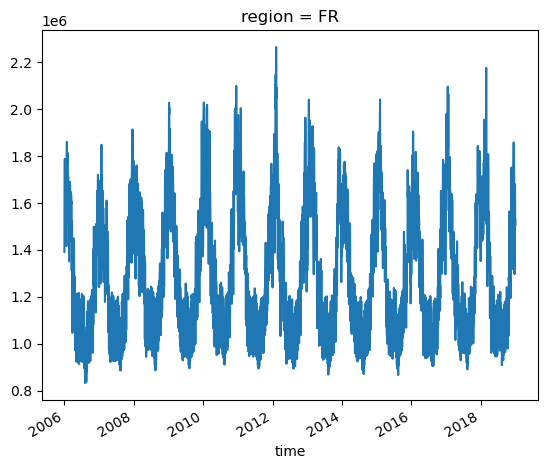

In [12]:
dem_da.plot()

### Predictors

In [13]:
files = fn.get_predictor_files("EU", "pop_dens_mask")

In [14]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override")

In [15]:
pred_ds = pred_ds.sel(region=region).expand_dims({"region": [region]}).compute()

In [16]:
pred_ds.data_vars

Data variables:
    hdd       (region, time) float64 8.329 9.109 10.6 ... 6.406 5.708 2.232
    t2min     (region, time) float64 nan 275.9 274.8 273.6 ... 278.8 278.0 283.4
    q         (region, time) float64 5.187 4.848 4.423 ... 6.038 6.935 7.073
    rh        (region, time) float64 83.59 81.16 82.06 ... 84.61 92.13 75.65
    msdwswrf  (region, time) float64 53.54 40.97 57.5 ... 34.07 17.45 45.65
    t2m       (region, time) float64 279.9 279.1 277.6 ... 281.7 282.4 285.9
    mtpr      (region, time) float64 9.475e-06 8.388e-05 ... 7.003e-05 1.753e-05
    t2max     (region, time) float64 nan 281.7 279.4 278.6 ... 283.4 285.6 287.6
    w10       (region, time) float64 3.19 5.238 3.507 ... 4.716 5.345 6.574
    cdd       (region, time) float64 0.0234 0.0234 0.02339 ... -0.0234 -0.0234

## Prepare data

In [99]:
time_cols = []

region_dfs = {}
for region in dem_da.region.values:
    df = fn.to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = fn.add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df

In [100]:
region_dfs[region]

,demand,hdd,t2min,q,rh,msdwswrf,t2m,mtpr,t2max,w10,cdd
2006-01-01,1.390770e+06,10.178964,274.796479,4.888303,88.941258,33.125020,277.947320,6.214945e-05,279.127615,3.793781,-0.010970
2006-01-02,1.558161e+06,10.695028,274.503888,4.500322,86.307625,39.402268,277.431213,1.867487e-05,278.424423,3.241071,-0.010972
2006-01-03,1.680000e+06,11.798648,273.395105,4.151874,86.700894,36.606263,276.327612,5.275213e-06,277.154429,2.158084,-0.010974
2006-01-04,1.723594e+06,13.290185,272.400731,3.830582,87.655900,37.088533,274.836071,1.861479e-05,276.806646,2.414497,-0.010976
2006-01-05,1.787870e+06,15.296176,270.764909,3.261183,87.059652,36.237966,272.830065,1.339876e-05,275.163238,2.443362,-0.010978
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,1.679940e+06,14.437971,271.373567,3.574216,90.101975,46.052033,273.667633,6.597771e-07,278.785039,1.157241,-0.020465
2018-12-28,1.669453e+06,13.481629,272.082502,3.926914,92.407628,31.136063,274.623937,2.072133e-06,277.174407,1.245639,-0.020467
2018-12-29,1.591212e+06,12.223964,272.926813,4.187872,90.334863,38.071980,275.881634,2.726528e-06,279.040583,2.155910,-0.020469
2018-12-30,1.501771e+06,10.341194,275.302160,4.936423,92.263853,33.221600,277.764391,2.643428e-06,280.434559,2.069817,-0.020471


## Split data into training and testing

Using this as a guide: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

As this is time series data, leave out the last two years for testing.

In [102]:
first_train_year = 2006
last_train_year = 2013

In [103]:
first_test_year = 2014
last_test_year = 2016

In [104]:
# Hold out last X years for testing
test_len = dem_da.sel(time=slice(str(first_test_year), str(last_test_year))).time.values.shape[0]

In [105]:
test_len

1096

In [106]:
# def sel_train_test(df, first_train_year, last_test_year):
#     """
#     Selects df for training and test years. Might be used to e.g.
#     exclude a validation set.
#     """
#     return df[(df.index.year >= first_train_year) & (df.index.year <= last_test_year)]

In [107]:
train_X, test_X, train_y, test_y = fn.split(
    fn.sel_train_test(region_dfs[region], first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

## Sequential feature selection

Chooses the predictors using forwards selection and a stopping criterion for a score.

In [180]:
# rf = RandomForestRegressor(
#     n_estimators=best_params["n_estimators"],
#     random_state=0
# )

In [25]:
rf = ExtraTreesRegressor(
    random_state=0
)

In [26]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

[2006 2006 2006 ... 2013 2013 2013]


In [27]:
%%time
model = fn.mlextend_sfs(train_X, train_y, rf, list(logo), True, scoring="neg_mean_absolute_error")

CPU times: user 3min 40s, sys: 9.83 s, total: 3min 49s
Wall time: 4min 18s


In [28]:
model.subsets_

{1: {'feature_idx': (5,),
  'cv_scores': array([-116995.56547147, -112568.69300383, -115184.28069398,
         -113811.71275163, -115533.10767272, -123617.93709792,
         -118660.79615484, -116943.70482179]),
  'avg_score': -116664.47470852389,
  'feature_names': ('5',)},
 2: {'feature_idx': (4, 5),
  'cv_scores': array([-103069.82715016,  -94016.91490443,  -95387.30442188,
          -90813.52661358, -107082.79552395,  -98961.29439343,
         -101407.67732099, -102889.04582698]),
  'avg_score': -99203.54826942593,
  'feature_names': ('4', '5')},
 3: {'feature_idx': (1, 4, 5),
  'cv_scores': array([ -95762.20557846,  -92206.87497474,  -91510.14559526,
          -89863.67766619, -101092.65844621,  -95656.36087617,
          -94234.0350833 ,  -94454.67042309]),
  'avg_score': -94347.5785804273,
  'feature_names': ('1', '4', '5')},
 4: {'feature_idx': (1, 4, 5, 6),
  'cv_scores': array([-95614.87016896, -88775.00682606, -90385.08856996, -85689.74161139,
         -98009.25789286, -9425

In [29]:
model.k_feature_idx_

(1, 2, 3, 4, 5, 6, 7, 9)

In [30]:
selected_features = list(region_dfs[region].columns[1:][list(model.k_feature_idx_)])
print(selected_features)

['t2min', 'q', 'rh', 'msdwswrf', 't2m', 'mtpr', 't2max', 'cdd']


In [111]:
# # Once we know the selected features, we can just input them to save running the model again
# selected_features = ['t2min', 'q', 'rh', 'msdwswrf', 't2m', 'mtpr', 't2max', 'cdd']

In [32]:
pd.DataFrame.from_dict(model.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(5,)","[-116995.56547147142, -112568.69300383214, -11...",-116664.474709,"(5,)",2771.802399,3180.176357,1201.993681
2,"(4, 5)","[-103069.82715016016, -94016.91490443335, -953...",-99203.548269,"(4, 5)",4437.696823,5091.509598,1924.409742
3,"(1, 4, 5)","[-95762.20557846407, -92206.87497474065, -9151...",-94347.57858,"(1, 4, 5)",2789.991869,3201.04571,1209.881555
4,"(1, 4, 5, 6)","[-95614.8701689589, -88775.00682606144, -90385...",-92205.62741,"(1, 4, 5, 6)",3257.559908,3737.501276,1412.6427
5,"(1, 3, 4, 5, 6)","[-93305.57622570764, -86820.14760305628, -8951...",-91315.603549,"(1, 3, 4, 5, 6)",3804.516819,4365.0422,1649.830875
6,"(1, 3, 4, 5, 6, 9)","[-88317.35673153335, -86108.01673138532, -9357...",-90146.766063,"(1, 3, 4, 5, 6, 9)",3573.630972,4100.139581,1549.707096
7,"(1, 2, 3, 4, 5, 6, 9)","[-88707.32331075959, -83607.41865299019, -9277...",-89951.113607,"(1, 2, 3, 4, 5, 6, 9)",3495.538589,4010.541727,1515.84229
8,"(1, 2, 3, 4, 5, 6, 7, 9)","[-88469.34247021278, -86038.35299121174, -9180...",-89907.233003,"(1, 2, 3, 4, 5, 6, 7, 9)",3153.791804,3618.444856,1367.643603
9,"(1, 2, 3, 4, 5, 6, 7, 8, 9)","[-87941.51682451717, -87188.10024133766, -9152...",-90072.247236,"(1, 2, 3, 4, 5, 6, 7, 8, 9)",3091.048486,3546.457467,1340.434928
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[-88115.05141492895, -86807.1957847536, -93415...",-90885.444989,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",3385.616092,3884.424177,1468.174337


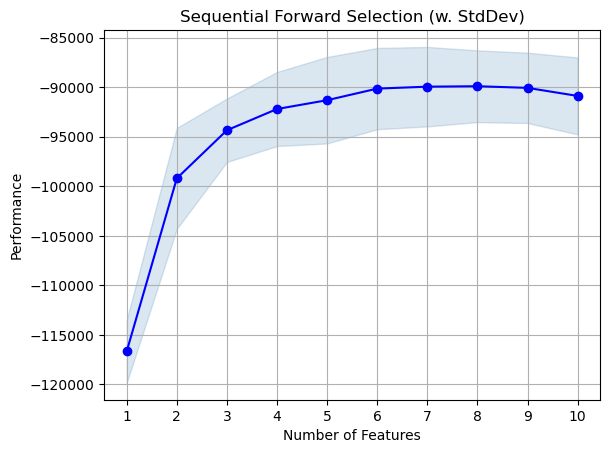

In [33]:
fig1 = plot_sfs(model.get_metric_dict(), kind='std_dev')
# plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

## Tune hyperparameters

Using leave one group out cross validation, where a group is a year.

In [145]:
parameters = {
    "n_estimators": randint(200, 500), # no. trees in the forest
    "min_samples_leaf": randint(1, 30), # min no. samples at leaf node
    "max_depth" : randint(5, 50), # max depth of each tree
    # "max_features" : uniform(0.2, 1) # max proportion of features to consider at split
    "max_leaf_nodes": randint(200, 500) # size of tree, how many end nodes
}

In [113]:
retain = ["demand"] + selected_features

In [114]:
final_features = region_dfs[region][retain]

In [115]:
final_features.head()

,demand,t2min,q,rh,msdwswrf,t2m,mtpr,t2max,cdd
2006-01-01,1.390770e+06,274.796479,4.888303,88.941258,33.125020,277.947320,0.000062,279.127615,-0.010970
2006-01-02,1.558161e+06,274.503888,4.500322,86.307625,39.402268,277.431213,0.000019,278.424423,-0.010972
2006-01-03,1.680000e+06,273.395105,4.151874,86.700894,36.606263,276.327612,0.000005,277.154429,-0.010974
2006-01-04,1.723594e+06,272.400731,3.830582,87.655900,37.088533,274.836071,0.000019,276.806646,-0.010976
2006-01-05,1.787870e+06,270.764909,3.261183,87.059652,36.237966,272.830065,0.000013,275.163238,-0.010978


In [116]:
train_X, test_X, train_y, test_y = fn.split(
    fn.sel_train_test(final_features, first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [117]:
rf = ExtraTreesRegressor()

In [118]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

[2006 2006 2006 ... 2013 2013 2013]


In [119]:
%%time
best_params = fn.tune_hyperparameters(
    train_X,
    train_y,
    rf,
    parameters,
    logo,
    n_iter=200
)

CPU times: user 41min 50s, sys: 8.8 s, total: 41min 59s
Wall time: 42min 36s


In [120]:
best_params

{'max_depth': 41,
 'max_leaf_nodes': 287,
 'min_samples_leaf': 7,
 'n_estimators': 972}

## Finalise model

In [121]:
# # to save tuning hyperparameters again, copy and paste best_params here
# best_params = dict(
#     max_depth=30,
#     max_leaf_nodes=97,
#     min_samples_leaf=13,
#     n_estimators=465
# )

In [122]:
rf = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_depth=best_params["max_depth"],
    max_leaf_nodes=best_params["max_leaf_nodes"],
    random_state=0,
)

In [123]:
model_train, pred_train = fn.predict_forest(train_y, train_X, train_X, rf)

In [124]:
model_test, pred_test = fn.predict_forest(train_y, train_X, test_X, rf)

In [125]:
pred_train.shape

(2922,)

In [126]:
pred_test.shape

(1096,)

## Evaluate performance

In [127]:
metric_names = ["R2", "MAE", "MSE", "MAPE", "MedAE"]
metrics = [r2_score, mean_absolute_error,
           mean_squared_error, mean_absolute_percentage_error, median_absolute_error]

In [128]:
train_scores = fn.compute_scores(train_y, pred_train, metrics)

In [206]:
train_scores

[0.8758203704904577,
 79010.11452973621,
 8815209446.827778,
 0.063069132687535,
 70385.85005082365]

In [129]:
train_scores

[0.898564849013669,
 70822.04228255867,
 7200634312.94419,
 0.05656304929707103,
 63866.296658914885]

In [130]:
test_scores = fn.compute_scores(test_y, pred_test, metrics)

In [208]:
test_scores

[0.8471874293724893,
 80618.97146089762,
 9219887062.316177,
 0.06481786067082755,
 71737.86914654123]

In [131]:
test_scores

[0.8447504202375762,
 81065.5188542037,
 9366923061.393118,
 0.06534119478780921,
 74627.84902245889]

In [132]:
def plot_scores(train, test, metric_names):
    """
    Subplot for each metric showing score for train and test.
    """
    fig, ax = plt.subplots(2, 3, figsize=(6, 3))
    for i, a in enumerate(ax.flatten()):
        if i < len(metric_names):
            a.bar(["Train", "Test"], [train[i], test[i]])
            a.set_title(metric_names[i])
    plt.tight_layout()

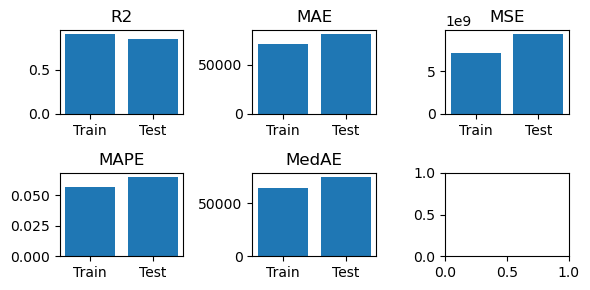

In [133]:
plot_scores(train_scores, test_scores, metric_names)

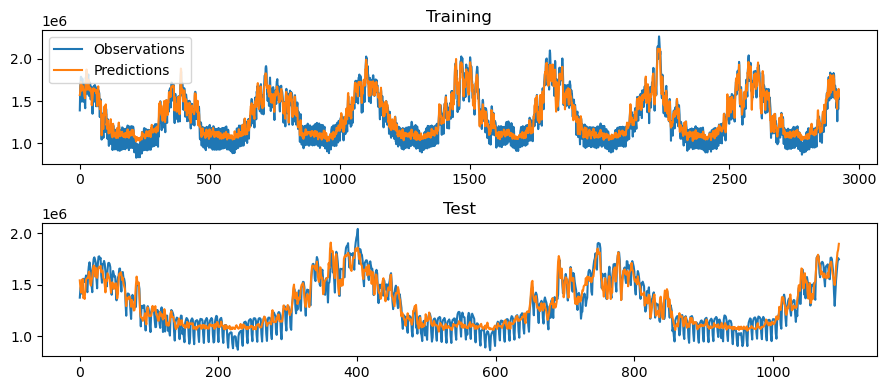

In [134]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

plt.tight_layout()

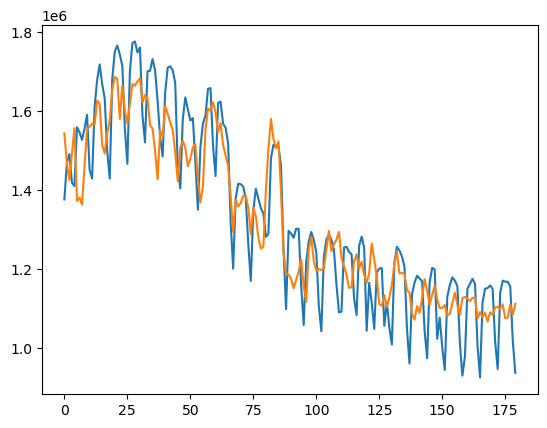

In [135]:
plt.plot(test_y[:180])
plt.plot(pred_test[:180])

# Non-weather model

In [136]:
df = pd.DataFrame(
    dem_da.sel(time=slice(str(first_train_year), str(last_test_year)), region=region).values,
    index=fn.sel_train_test(region_dfs[region], first_train_year, last_test_year).index,
    columns=["demand"]
)

In [137]:
df["pred"] = np.append(pred_train, pred_test)

In [138]:
time_cols = ["is_weekend", "month_int"]
for t in time_cols:
    df = fn.add_time_column(df, t)

In [139]:
df

,demand,pred,is_weekend,month_int
2006-01-01,1.390770e+06,1.573114e+06,1,1
2006-01-02,1.558161e+06,1.586817e+06,0,1
2006-01-03,1.680000e+06,1.645750e+06,0,1
2006-01-04,1.723594e+06,1.690576e+06,0,1
2006-01-05,1.787870e+06,1.725163e+06,0,1
...,...,...,...,...
2016-12-27,1.547058e+06,1.682532e+06,0,12
2016-12-28,1.625044e+06,1.741240e+06,0,12
2016-12-29,1.708560e+06,1.813115e+06,0,12
2016-12-30,1.758649e+06,1.839712e+06,0,12


In [140]:
train_X, test_X, train_y, test_y = fn.split(
    fn.sel_train_test(df, first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [141]:
rf = ExtraTreesRegressor(
    random_state=0
)

In [142]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

[2006 2006 2006 ... 2013 2013 2013]


In [143]:
%%time
model = fn.mlextend_sfs(train_X, train_y, rf, list(logo), True, scoring="neg_mean_absolute_error")

CPU times: user 10.1 s, sys: 413 ms, total: 10.5 s
Wall time: 10.8 s


In [144]:
model.subsets_

{1: {'feature_idx': (0,),
  'cv_scores': array([-77286.89591658, -77011.48440446, -80334.67136223, -77378.0456605 ,
         -80961.99644292, -80555.18270887, -85082.18934502, -77811.34380554]),
  'avg_score': -79552.72620576384,
  'feature_names': ('0',)},
 2: {'feature_idx': (0, 1),
  'cv_scores': array([-51832.01216346, -49152.0225424 , -56955.6036736 , -49697.41238912,
         -55317.66485043, -52533.57748803, -56460.17107593, -53115.00066339]),
  'avg_score': -53132.93310579362,
  'feature_names': ('0', '1')},
 3: {'feature_idx': (0, 1, 2),
  'cv_scores': array([-49288.12938159, -48104.77145974, -51619.5748423 , -44981.94053519,
         -48092.95742114, -52481.68801946, -51881.82675033, -46047.29884105]),
  'avg_score': -49062.2734063508,
  'feature_names': ('0', '1', '2')}}

In [146]:
model.k_feature_idx_

(0, 1, 2)

In [147]:
selected_features = list(df.columns[1:][list(model.k_feature_idx_)])
print(selected_features)

['pred', 'is_weekend', 'month_int']


In [148]:
# # Once we know the selected features, we can just input them to save running the model again
# selected_features = ['msdwswrf', 'w10', 'cdd', 'hdd', 'rh', 't2min', 'mtpr', 'q', 't2max']

In [149]:
pd.DataFrame.from_dict(model.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[-77286.89591657762, -77011.48440445529, -8033...",-79552.726206,"(0,)",2254.594124,2586.766983,977.70602
2,"(0, 1)","[-51832.01216345884, -49152.02254239672, -5695...",-53132.933106,"(0, 1)",2390.097107,2742.233832,1036.466965
3,"(0, 1, 2)","[-49288.12938158914, -48104.77145974041, -5161...",-49062.273406,"(0, 1, 2)",2260.855541,2593.950904,980.421286


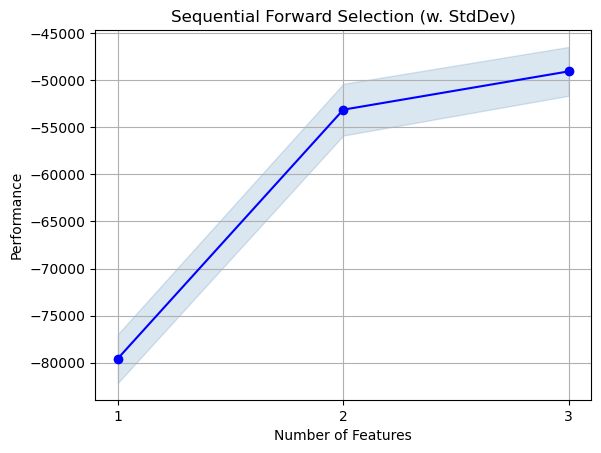

In [150]:
fig1 = plot_sfs(model.get_metric_dict(), kind='std_dev')
# plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

## Tune hyperparameters

Using leave one group out cross validation, where a group is a year.

In [151]:
parameters = {
    "n_estimators": randint(200, 500), # no. trees in the forest
    "min_samples_leaf": randint(1, 30), # min no. samples at leaf node
    "max_depth" : randint(5, 50), # max depth of each tree
    # "max_features" : uniform(0.2, 1) # max proportion of features to consider at split
    "max_leaf_nodes": randint(200, 500) # size of tree, how many end nodes
}

In [152]:
retain = ["demand"] + selected_features

In [153]:
final_features = df[retain]

In [154]:
final_features.head()

,demand,pred,is_weekend,month_int
2006-01-01,1.390770e+06,1.573114e+06,1,1
2006-01-02,1.558161e+06,1.586817e+06,0,1
2006-01-03,1.680000e+06,1.645750e+06,0,1
2006-01-04,1.723594e+06,1.690576e+06,0,1
2006-01-05,1.787870e+06,1.725163e+06,0,1


In [155]:
train_X, test_X, train_y, test_y = fn.split(
    fn.sel_train_test(final_features, first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [156]:
# # very restricted space for testing
# parameters = {
#     "n_estimators": randint(10, 12), # no. trees in the forest
# }

In [157]:
rf = ExtraTreesRegressor()

In [158]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

[2006 2006 2006 ... 2013 2013 2013]


In [159]:
%%time
best_params = fn.tune_hyperparameters(
    train_X,
    train_y,
    rf,
    parameters,
    logo,
    n_iter=200
)

CPU times: user 11min 23s, sys: 4.12 s, total: 11min 27s
Wall time: 11min 39s


In [160]:
best_params

{'max_depth': 8,
 'max_leaf_nodes': 451,
 'min_samples_leaf': 4,
 'n_estimators': 209}

## Finalise model

In [161]:
# # to save tuning hyperparameters again, copy and paste best_params here
# best_params = dict(
#     max_depth=29,
#     max_leaf_nodes=99,
#     min_samples_leaf=14,
#     n_estimators=474
# )

In [162]:
rf = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_depth=best_params["max_depth"],
    max_leaf_nodes=best_params["max_leaf_nodes"],
    random_state=0,
)

In [163]:
model_train, pred_train = fn.predict_forest(train_y, train_X, train_X, rf)

In [164]:
model_test, pred_test = fn.predict_forest(train_y, train_X, test_X, rf)

In [165]:
pred_train.shape

(2922,)

In [166]:
pred_test.shape

(1096,)

## Evaluate performance

In [167]:
train_scores = fn.compute_scores(train_y, pred_train, metrics)

In [ ]:
train_scores

[0.9556024185448866,
 41005.65789348936,
 3151676172.695838,
 0.031763992230464166,
 30905.12581863854]

In [168]:
train_scores

[0.9656162076346302,
 36391.73659248635,
 2440821674.8116627,
 0.028316689586289013,
 28249.00276337797]

In [169]:
test_scores = fn.compute_scores(test_y, pred_test, metrics)

In [262]:
test_scores

[0.9392949815221872,
 43636.509143824325,
 3662613698.486468,
 0.034188055128647206,
 33091.760739602265]

In [170]:
test_scores

[0.9375887719978391,
 46012.263463841235,
 3765557187.0655756,
 0.036426261808414406,
 35892.71310619591]

In [171]:
def plot_scores(train, test, metric_names):
    """
    Subplot for each metric showing score for train and test.
    """
    fig, ax = plt.subplots(2, 3, figsize=(6, 3))
    for i, a in enumerate(ax.flatten()):
        if i < len(metric_names):
            a.bar(["Train", "Test"], [train[i], test[i]])
            a.set_title(metric_names[i])
    plt.tight_layout()

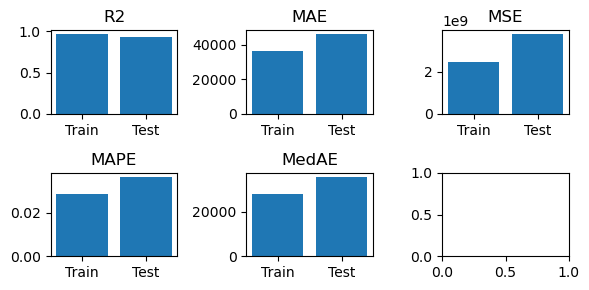

In [172]:
plot_scores(train_scores, test_scores, metric_names)

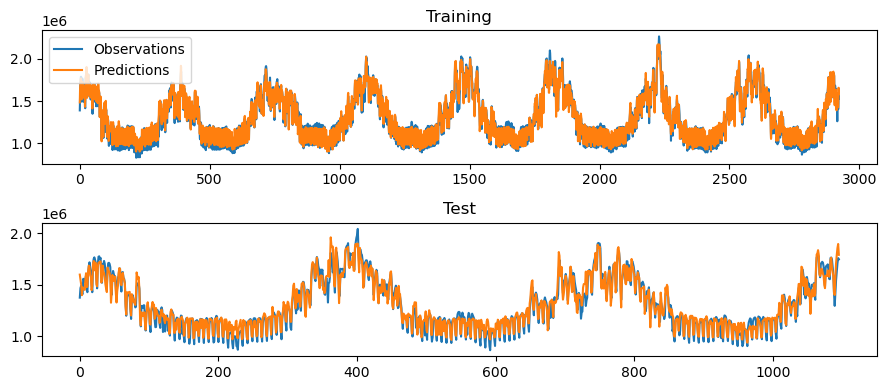

In [173]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

plt.tight_layout()

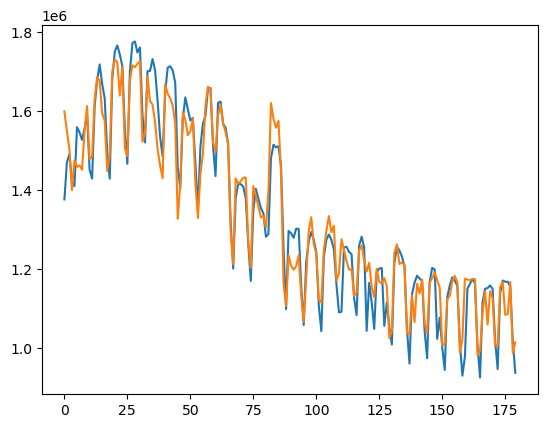

In [174]:
plt.plot(test_y[:180])
plt.plot(pred_test[:180])

## Performance by day of the week

In [175]:
error_df = pd.DataFrame(
    test_y,
    index = final_features[
        (final_features.index.year >= first_test_year) &
        (final_features.index.year <= last_test_year)
    ].index,
    columns=["demand"]
)

In [176]:
error_df["prediction"] = pred_test

In [177]:
error_df["abs_error"] = np.abs(test_y - pred_test)

In [178]:
error_df["sq_error"] = (test_y - pred_test) ** 2

In [179]:
error_df["abs_error"].groupby(error_df.index.weekday).mean()

0    51892.772428
1    39774.793029
2    45035.063708
3    48069.245813
4    45999.570527
5    33266.867169
6    58122.392513
Name: abs_error, dtype: float64

In [180]:
error_df["sq_error"].groupby(error_df.index.weekday).mean()

0    4.638407e+09
1    2.631389e+09
2    3.562930e+09
3    4.417772e+09
4    4.739197e+09
5    1.840675e+09
6    4.531746e+09
Name: sq_error, dtype: float64

In [94]:
train_y.shape[0] + test_y.shape[0]

4018

# Note:

### The below are validation set results, where the training and test set results are predictions of predictions, not predictions of demand...

### And now on validation set

In [254]:
last_test_year

2016

In [276]:
time_cols = ["is_weekend"]

region_dfs = {}
for region in dem_da.region.values:
    df = fn.to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = fn.add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df

In [277]:
region_dfs[region]

,demand,is_weekend,msdwswrf,w10,t2m,cdd,hdd,rh,t2min,mtpr,q,t2max
2006-01-01,1.390770e+06,1,33.469701,2.968107,277.120854,-0.009722,11.013986,87.793425,274.126953,0.000044,4.606783,278.299142
2006-01-02,1.558161e+06,0,38.620781,2.234833,276.025270,-0.009723,12.109568,88.337877,272.778723,0.000021,4.223533,277.842970
2006-01-03,1.680000e+06,0,38.505117,1.849658,275.761280,-0.009725,12.373554,87.220708,272.670548,0.000014,4.090290,277.582042
2006-01-04,1.723594e+06,0,40.630597,2.490590,274.708175,-0.009727,13.426657,86.078723,271.983277,0.000009,3.725595,276.859842
2006-01-05,1.787870e+06,0,38.203008,2.962313,274.200237,-0.009729,13.934592,84.712166,271.639411,0.000008,3.543822,276.056212
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,1.679940e+06,0,40.692448,1.612725,275.848274,-0.018136,12.273452,87.795194,273.492140,0.000002,4.168545,279.485340
2018-12-28,1.669453e+06,0,38.997165,1.929787,276.401266,-0.018138,11.720458,89.504321,273.725989,0.000002,4.416365,279.349883
2018-12-29,1.591212e+06,1,36.062917,3.070928,277.571661,-0.018140,10.550060,88.539303,274.841585,0.000012,4.729524,280.415372
2018-12-30,1.501771e+06,1,36.289060,3.001991,278.441629,-0.018142,9.680090,86.732386,275.520617,0.000011,4.884352,280.783025


In [278]:
val_df = region_dfs[region][region_dfs[region].index.year > last_test_year][retain]

In [279]:
val_df

,demand,is_weekend,msdwswrf,w10,cdd,hdd,rh,t2min,mtpr
2017-01-01,1.659144e+06,1,44.670932,2.466691,-0.016850,14.462713,85.871348,271.221378,0.000020
2017-01-02,1.789642e+06,0,43.027224,2.444115,-0.016852,13.966171,87.167600,271.488706,0.000017
2017-01-03,1.905787e+06,0,40.617101,3.513182,-0.016854,13.115048,86.150884,271.946796,0.000022
2017-01-04,1.936445e+06,0,41.624294,3.887854,-0.016855,12.382174,82.299249,272.166419,0.000024
2017-01-05,1.904558e+06,0,52.568151,2.683660,-0.016857,14.971627,77.671090,269.595248,0.000013
...,...,...,...,...,...,...,...,...,...
2018-12-27,1.679940e+06,0,40.692448,1.612725,-0.018136,12.273452,87.795194,273.492140,0.000002
2018-12-28,1.669453e+06,0,38.997165,1.929787,-0.018138,11.720458,89.504321,273.725989,0.000002
2018-12-29,1.591212e+06,1,36.062917,3.070928,-0.018140,10.550060,88.539303,274.841585,0.000012
2018-12-30,1.501771e+06,1,36.289060,3.001991,-0.018142,9.680090,86.732386,275.520617,0.000011


In [280]:
val_y = val_df["demand"].values

In [281]:
val_y.shape

(730,)

In [283]:
val_X = np.array(val_df.drop("demand", axis=1))

In [284]:
val_X.shape

(730, 8)

In [285]:
model_test, pred_val = fn.predict_forest(train_y, train_X, val_X, rf)

In [286]:
pred_val.shape

(730,)

## Evaluate performance

In [287]:
val_scores = fn.compute_scores(val_y, pred_val, metrics)

In [288]:
val_scores

[0.8798333222182046,
 80679.3740568326,
 8998720766.88126,
 0.06330106762601136,
 72001.870730213]

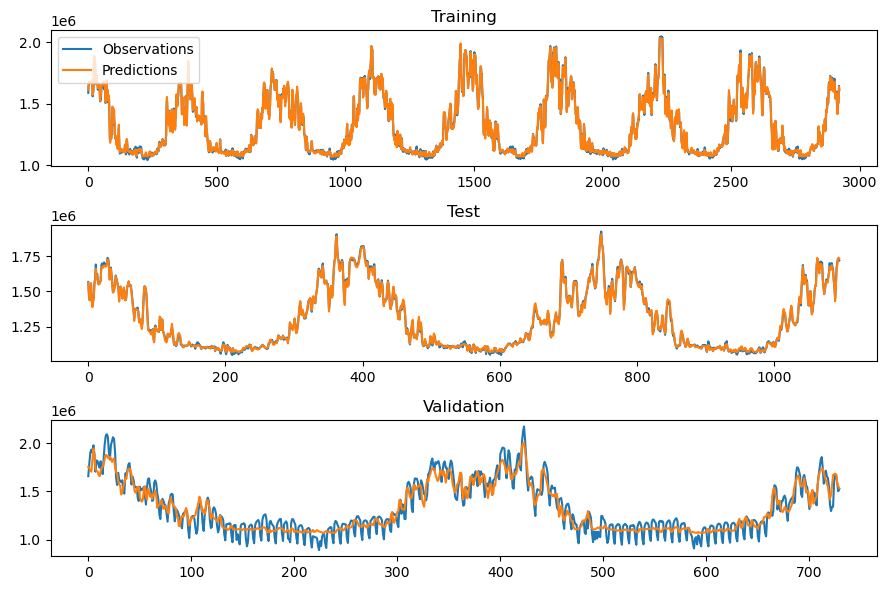

In [290]:
fig, ax = plt.subplots(3, 1, figsize=(9, 6))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

ax[2].plot(val_y)
ax[2].plot(pred_val)
ax[2].set_title("Validation")

plt.tight_layout()